# Experiments

A way to generate test multiple methods on multiple datasets and view the results in a grid.

In [1]:
from drnb.experiment import Experiment

In [2]:
experiment = Experiment(
    name="pca-vs-randproj",
)

[23:31:04] WARNING  Experiment directory already exists:                              ]8;id=420952;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=951180;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#81\81]8;;\
                    /home/james/rdev/datasets/experiments/pca-vs-randproj. Existing                 
                    shards may be reused; use a new name or clear_storage() if you                  
                    want a fresh run.                                                               

For a given experiment name everything goes into a folder under
`$DRNB_HOME/experiments/<experiment name>`. If that folder already exists then you will get a
warning when you create it. As the message notes, you can call `clear_storage` to start fresh.
In general, I would recommend just creating a different name. Default naming uses a datestamp to
reduce the risk of accidentally overwriting old results.

In [3]:
experiment.clear_storage()

           WARNING  Deleting experiment storage at                                   ]8;id=531439;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=606426;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#355\355]8;;\
                    /home/james/rdev/datasets/experiments/pca-vs-randproj                           

There is a `methods` constructor field you can use to set the methods if you know what they are
but you can also add them one at a time. Because a lot of methods need parameterization, it can be
a bit awkward to specify them in one list. 

In [4]:
experiment.add_method("pca")
experiment.add_method(
    "randproj",
    params=dict(
        random_state=42,
        density=1 / 3.0,
    ),
)

Similarly, you can add datasets with the `datasets` constructor field or add them as a list later.
Some very basic validation is done, e.g. it's an error to try and add the same dataset twice.

In [5]:
experiment.add_datasets(["iris", "s1k"])

You can also add evaluations either in the `evaluations` argument of the constructor or by adding
them via `add_evaluations`:

In [6]:
experiment.add_evaluations(
    [
        "rte",
        ("nnp", dict(n_neighbors=[15])),
    ]
)

To run the experiment, call the `run` method.

Experiments save results into the results folder which is `$DRNB_HOME/experiments` as they go. In
the event of disaster there is some checkpointing, so you may be able to pick up from where you
left off.

In [7]:
experiment.run()

           INFO     Experiment pca-vs-randproj writing to                            ]8;id=186920;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=516465;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#165\165]8;;\
                    /home/james/rdev/datasets/experiments/pca-vs-randproj                           

[23:31:09] INFO     Running pca on iris                                              ]8;id=826549;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=368592;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:31:13] INFO     Running pca on s1k                                               ]8;id=294779;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=796655;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:31:16] INFO     Running randproj on iris                                         ]8;id=603346;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=38001;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:31:21] INFO     Running randproj on s1k                                          ]8;id=991457;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=565696;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

## Plotting

When plotting the results, the coordinates will be rigid-body aligned (and optionally reflected) to
minimize the RMSD deviation from the first result for each method so that the plots are in the same
frame of reference to the greatest possible extent. No stretching of the axes is done however.

In [8]:
experiment.versions()["pca"]

{'package': 'scikit-learn', 'version': '1.6.0'}

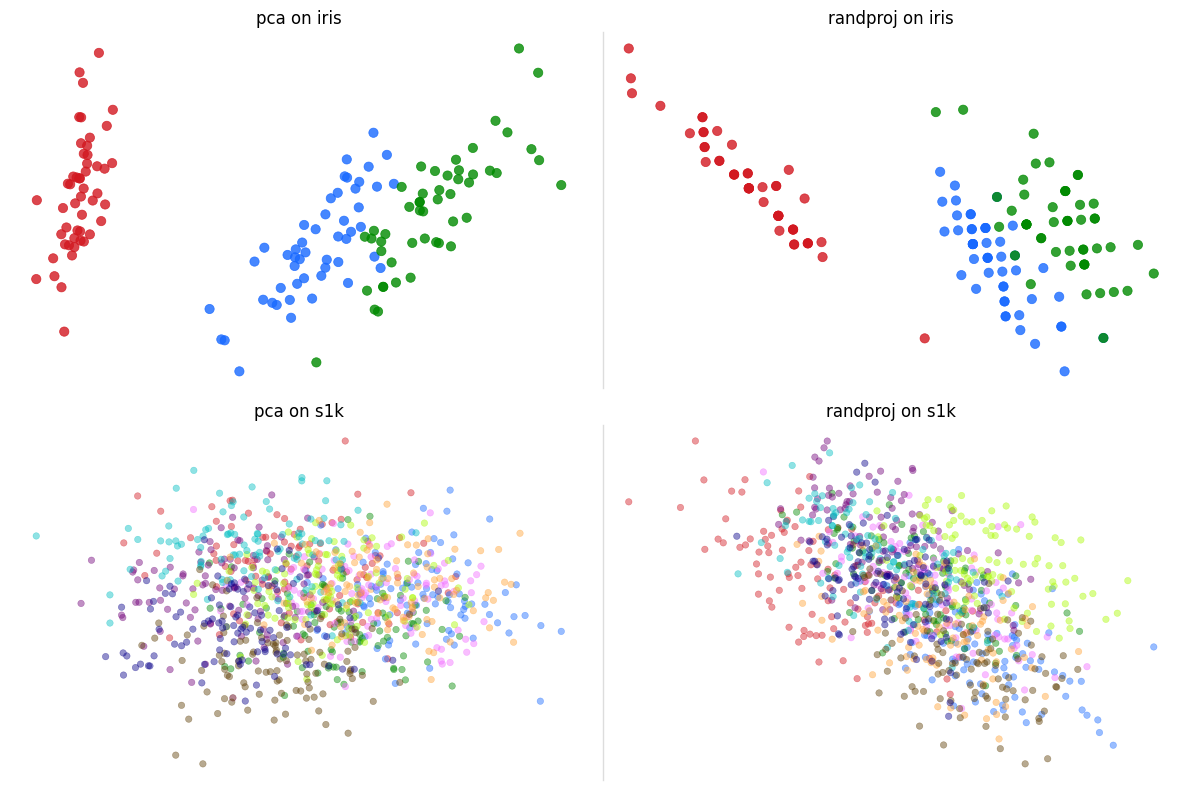

In [9]:
experiment.plot()

## Evaluations

The result of the evaluations can be viewed in a dataframe with the `to_df` method:

In [10]:
experiment.to_df()

method       pca           randproj          
metric     rte-5    nnp-15    rte-5    nnp-15
iris    0.978667  0.800444    0.776  0.491556
s1k        0.662  0.085067   0.6336    0.0866

Under normal circumstances, that is all (in fact, more) than you need to know to work with
experiments. Some more advanced stuff follows.

## Checkpointing

Experiments try to save their progress as they go, so you can incrementally add data, methods or
evals as you go.

The status of an experiment can be checked with `status()` which returns a dataframe.

In [11]:
experiment.status()

,pca,randproj
iris,completed,completed
s1k,completed,completed


If the experiment has not been run yet, then the status will be `missing`. If the experiment
completed then it will show as `completed`. There is a third status `evals_partial(x/y)` that will 
appear if a task completed but subsequently we added a new eval. The numbers in parentheses indicate
the number of evals completed and then the total number of evals, e.g. `evals_partial(1/3)` means
one out of the three requested evals has been completed. This state can occur due to merging 
experiments (see below), even if you don't add an evaluation manually after calling  `run()`.

To prove the point about recovering from a failed run, we can clear the result for the `pca` method
on the `iris` dataset with `clear_task` and rerun it.

In [12]:
experiment.clear_task("pca", "iris")

You should still be able to see the data that is present via `to_df()` and `plot()` with suitable
placeholders for the hole in the data.

In [13]:
experiment.to_df()

method    pca           randproj          
metric  rte-5    nnp-15    rte-5    nnp-15
iris      NaN       NaN    0.776  0.491556
s1k     0.662  0.085067   0.6336    0.0866

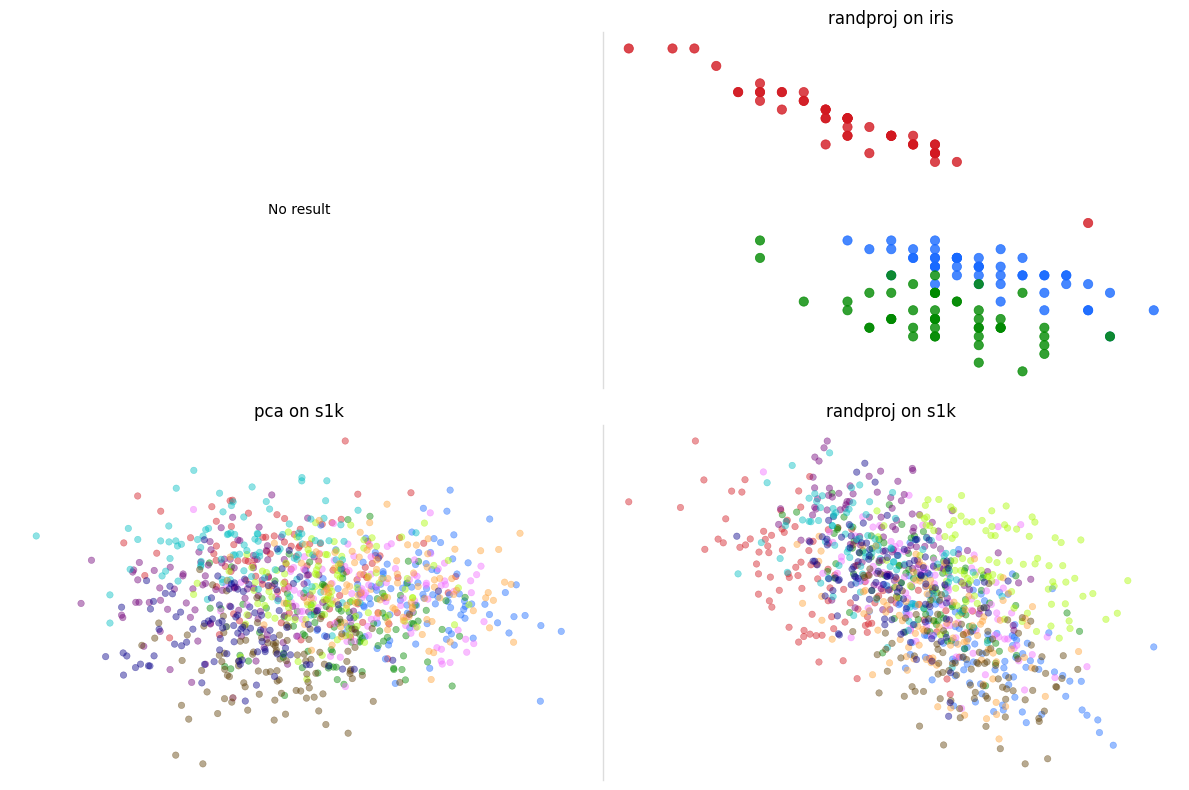

In [14]:
experiment.plot()

the `status` also updates to reflect the missing data.

In [15]:
experiment.status()

,pca,randproj
iris,missing,completed
s1k,completed,completed


Now if we call `run` again...

In [16]:
experiment.run()

[23:31:32] INFO     Experiment pca-vs-randproj writing to                            ]8;id=630536;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=209258;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#165\165]8;;\
                    /home/james/rdev/datasets/experiments/pca-vs-randproj                           

           INFO     Running pca on iris                                              ]8;id=684575;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=11963;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:31:35] INFO     Skipping pca on s1k (already completed)                          ]8;id=28195;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=520634;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#194\194]8;;\

           INFO     Skipping randproj on iris (already completed)                    ]8;id=911569;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=90187;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#194\194]8;;\

           INFO     Skipping randproj on s1k (already completed)                     ]8;id=895929;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=14893;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#194\194]8;;\

...only the `pca/iris` run is executed. The status should now be updated also:

In [17]:
experiment.status()

,pca,randproj
iris,completed,completed
s1k,completed,completed


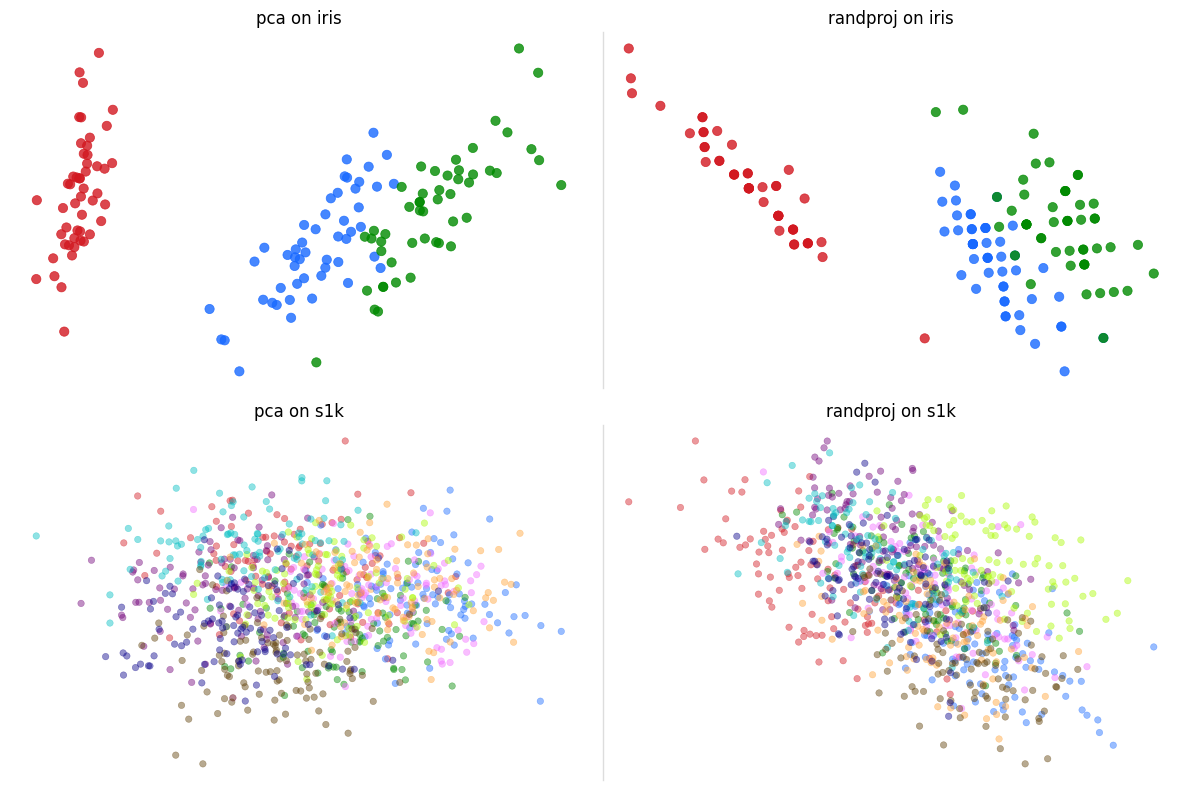

In [18]:
experiment.plot()

There's not much general use for `clear_task` except if
something went really weird with the output, but the checkpointing thought it finished correctly.

## Reading Experiments

Because of checkpointing, you shouldn't need to explicitly save the experiment to disk, as long as
you call `run()`. There is a `save` method, but it would only be needed if you want to create an
experiment, but not run it, and then you want to open it from a new session.

To read an experiment, use `read_experiment()`, passing in the experiment name:

In [19]:
from drnb.experiment import read_experiment

exp = read_experiment("pca-vs-randproj")

[23:31:38] INFO     Reading experiment pca-vs-randproj from                          ]8;id=880170;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=569770;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#573\573]8;;\
                    /home/james/rdev/datasets/experiments/pca-vs-randproj                           

You should be able to retrieve the plot and eval data.

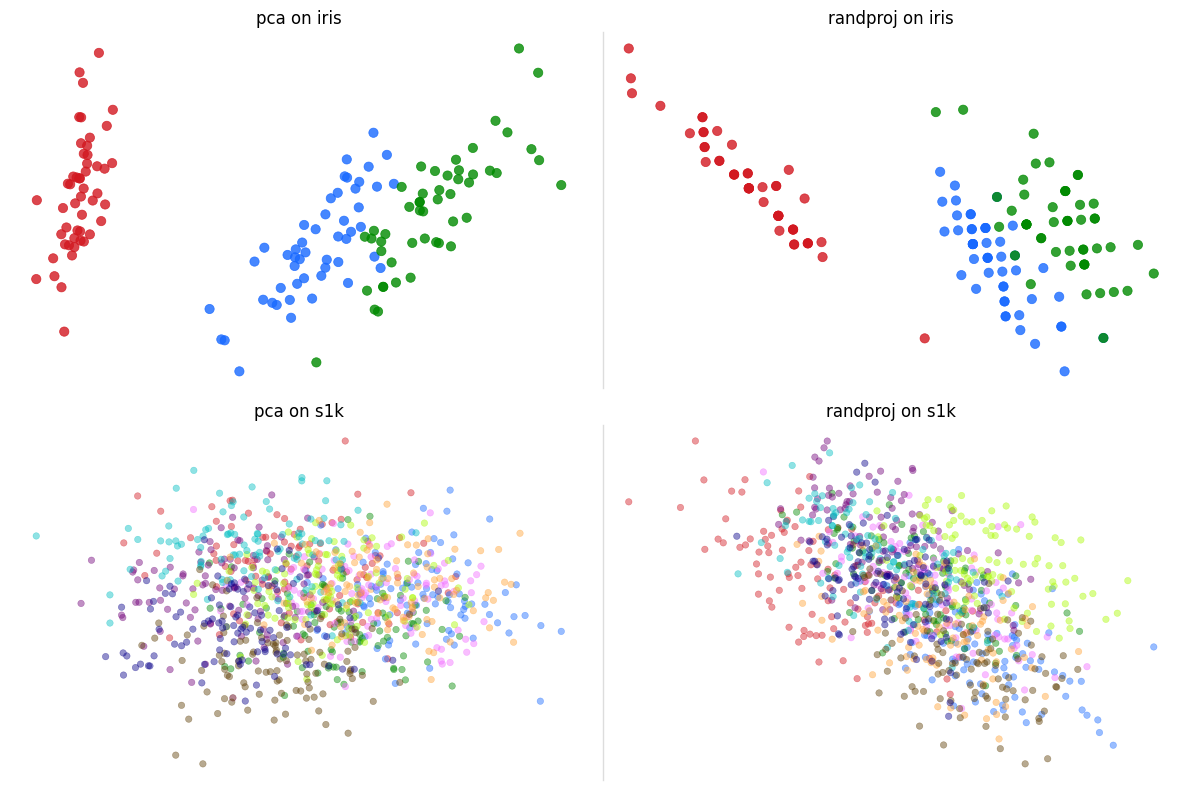

In [20]:
exp.plot()

In [21]:
exp.to_df()

method       pca           randproj          
metric     rte-5    nnp-15    rte-5    nnp-15
iris    0.978667  0.800444    0.776  0.491556
s1k        0.662  0.085067   0.6336    0.0866

## Merging and Updating Experiments

If you are comparing a lot of different embedding methods (i.e. the whole point of this repo), it's
likely you will have a set of go-to methods, datasets and evals you like to use, e.g. PCA, t-SNE
and UMAP, using nearest neighbor preservation at 15 and 50 neighbors on MNIST and Fashion MNIST.

Rather than grind through all of that every time you want to compare this performance with a
different embedding method, you might want to create one base experiment with just those results
and then either read that experiment in or merge it with the results of another experiment, e.g.
one on a new embedding.

In this slightly contrived example, I am carrying out a new experiment of applying t-SNE to the
`penguins` dataset and doing an eval of nnp50 (50-nearest neighbor preservation).


In [22]:
experiment2 = Experiment(
    name="tsne-exp",
    evaluations=[("nnp", dict(n_neighbors=[50]))],
)
experiment2.clear_storage()
experiment2.add_method("tsne")
experiment2.add_dataset("penguins")
experiment2.run()

[23:31:40] WARNING  Experiment directory already exists:                              ]8;id=276373;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=672622;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#81\81]8;;\
                    /home/james/rdev/datasets/experiments/tsne-exp. Existing shards                 
                    may be reused; use a new name or clear_storage() if you want a                  
                    fresh run.                                                                      

           WARNING  Deleting experiment storage at                                   ]8;id=807216;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=313301;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#355\355]8;;\
                    /home/james/rdev/datasets/experiments/tsne-exp                                  

           INFO     Experiment tsne-exp writing to                                   ]8;id=740486;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=499473;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#165\165]8;;\
                    /home/james/rdev/datasets/experiments/tsne-exp                                  

           INFO     Running tsne on penguins                                         ]8;id=845713;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=975313;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:31:42] WARNING  Using k_neighbors (no self) = 90 with perplexity 30.00           ]8;id=504470;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py\external.py]8;;\:]8;id=848749;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py#339\339]8;;\

           WARNING  Running openTSNE.TSNE with params={}                             ]8;id=329986;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py\external.py]8;;\:]8;id=338231;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py#339\339]8;;\

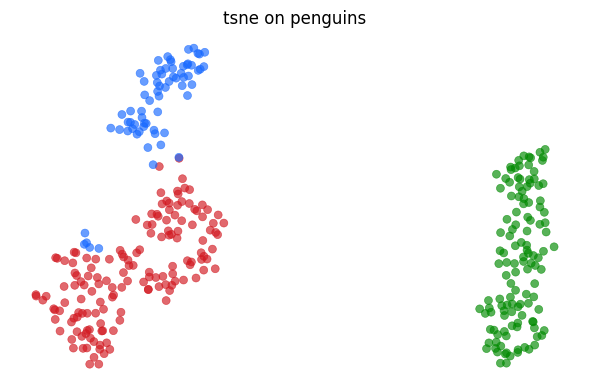

In [23]:
experiment2.plot()

To merge it with the previous experiment, we can use the `merge_experiments` function. There is
an optional `name` argument to `merge_experiments` which will give the experiment a new name. If
you don't use it, you get the concatenation of the two experiments with a `merged-` prefix, which
is hardly elegant.

**STALE DATA ALERT**: If you create a merged experiment and that folder already exists, then the 
data already used in the folder would be used instead of the data from the original two experiments. 
This will give inconsistent and likely wrong results. In that case, `merge_experiments` will fail
and raise an error.

This is just the price you pay for checkpointing and ignoring any warnings about pre-existing
data. In practice, you will want to make sure you always have a unique new name for the merged data.
If you really don't care about what was in that folder, then use `overwrite=True`, which I am doing
below because I want this notebook to be repeatable, but be very careful about doing something
destructive to your data this way.

In [24]:
from drnb.experiment import merge_experiments

# Avoid using overwrite=True in practice unless you know what you are doing!
merged_experiments = merge_experiments(experiment, experiment2, overwrite=True)
merged_experiments.name

'merged-pca-vs-randproj-tsne-exp'

Merging the experiments will create the union of the two experiments, with holes for any method and 
dataset that hasn't yet been tried. In addition if you have specified an eval in either of the
experiments that isn't in the other one, then that will show as a hole in the dataframe of results.

In [25]:
merged_experiments.to_df()

method         pca                  randproj                   tsne         \
metric       rte-5    nnp-15 nnp-50    rte-5    nnp-15 nnp-50 rte-5 nnp-15   
iris      0.978667  0.800444   None    0.776  0.491556   None   NaN    NaN   
s1k          0.662  0.085067   None   0.6336    0.0866   None   NaN    NaN   
penguins       NaN       NaN    NaN      NaN       NaN    NaN  None   None   

method              
metric      nnp-50  
iris           NaN  
s1k            NaN  
penguins  0.775731

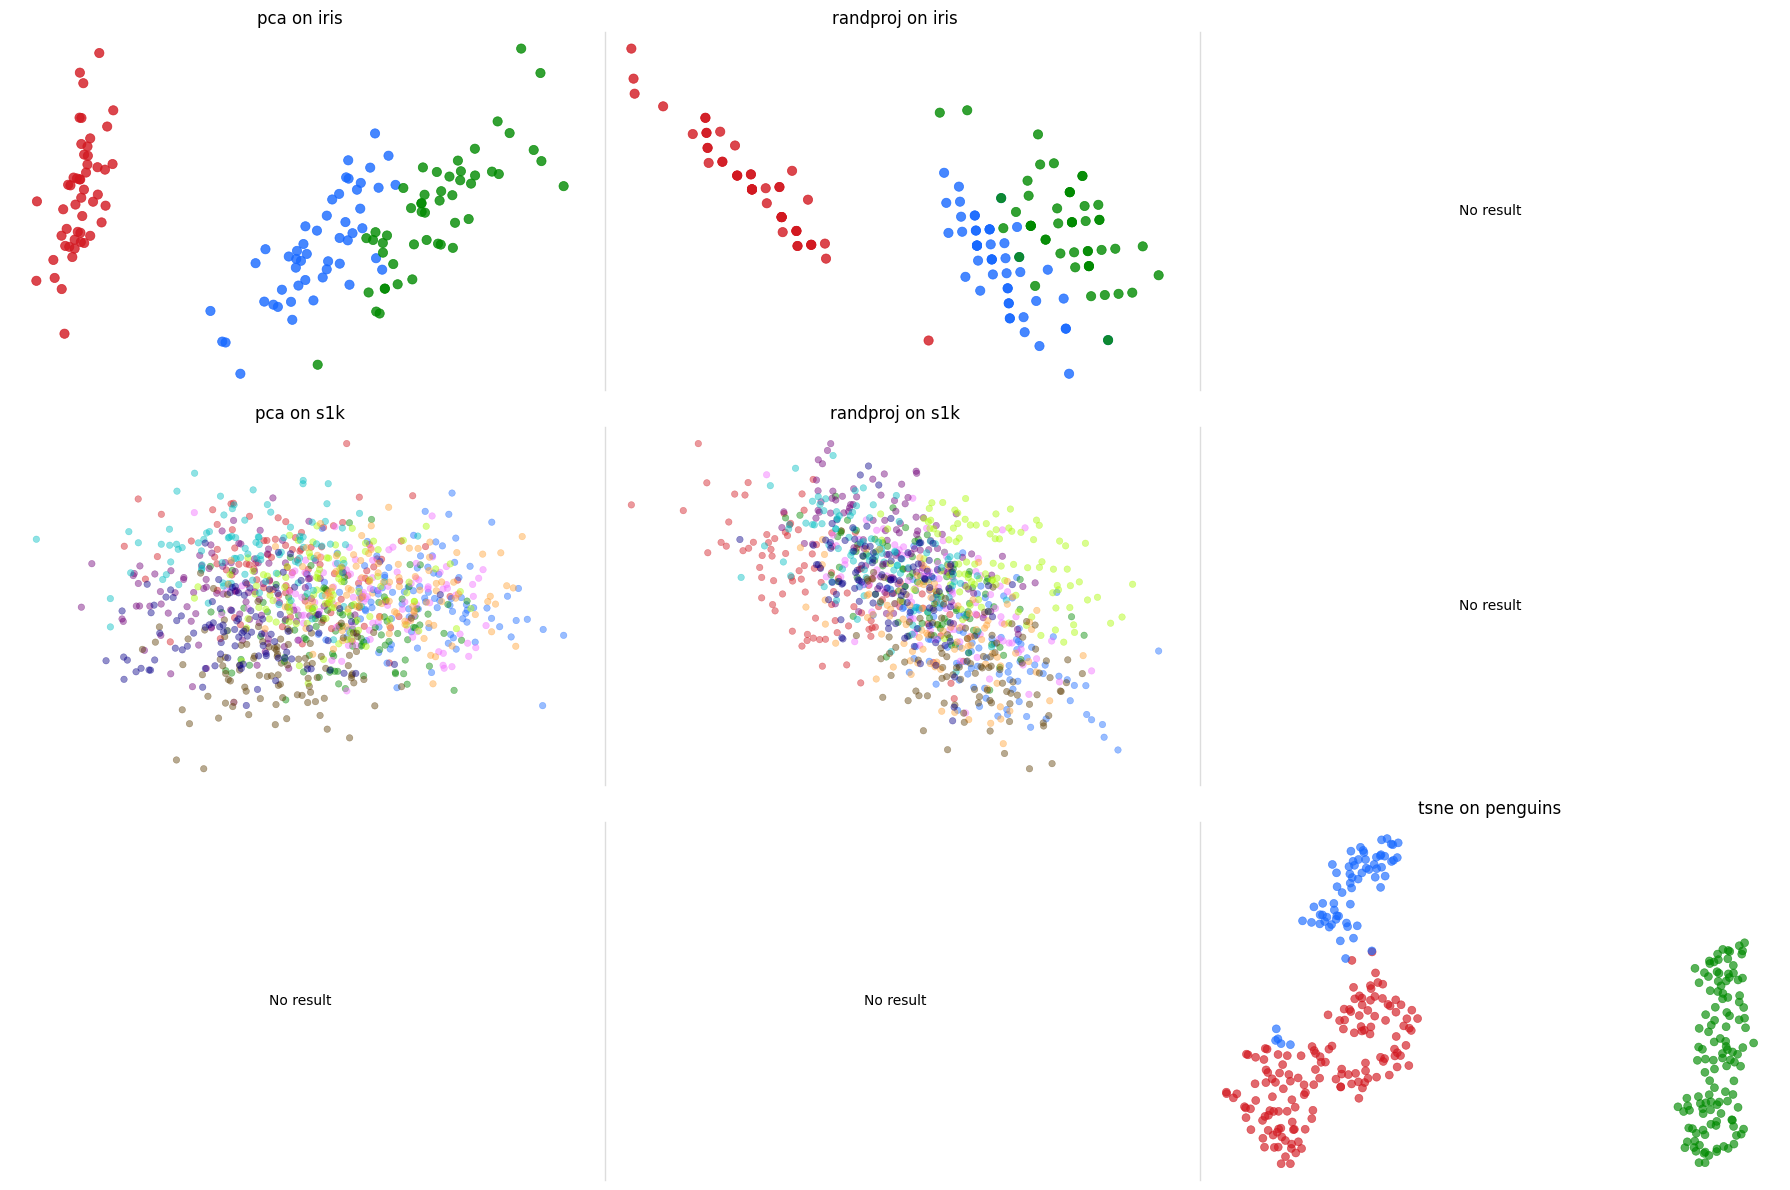

In [26]:
merged_experiments.plot()

In [27]:
merged_experiments.status()

,pca,randproj,tsne
iris,evals_partial(2/3),evals_partial(2/3),missing
s1k,evals_partial(2/3),evals_partial(2/3),missing
penguins,missing,missing,evals_partial(1/3)


In [28]:
merged_experiments.run()

[23:31:52] INFO     Experiment merged-pca-vs-randproj-tsne-exp writing to            ]8;id=751509;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=788832;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#165\165]8;;\
                    /home/james/rdev/datasets/experiments/merged-pca-vs-randproj-tsn                
                    e-exp                                                                           

           INFO     Reusing coords for pca on iris; computing 1 missing evaluations  ]8;id=378806;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=181807;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#220\220]8;;\

           INFO     nnp-[50]-noself-euclidean                                             ]8;id=610612;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=655160;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=263211;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=120493;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-tgkts9tb/request.json                              

           INFO     [faiss] request metric=euclidean n_neighbors=51                  ]8;id=909638;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=250832;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=772819;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=439791;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=44801;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=625579;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=268572;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=763311;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 14, in _load_faiss                                                   

           INFO         import faiss  # type: ignore                                 ]8;id=723096;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=694872;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         ^^^^^^^^^^^^                                                 ]8;id=334280;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=433200;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     ModuleNotFoundError: No module named 'faiss'                     ]8;id=954694;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=340312;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                                                                      ]8;id=739939;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=999885;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     The above exception was the direct cause of the following        ]8;id=116054;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=232302;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    exception:                                                                      

           INFO                                                                      ]8;id=324735;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=692578;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=532854;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=302083;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=343419;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=213569;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/.venv/lib/python3.                
                    12/site-packages/drnb_nn_plugin_sdk/helpers/runner.py", line 36,                
                    in run_nn_plugin                                                                

           INFO         response = handler(request)                                  ]8;id=169926;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=286970;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                    ^^^^^^^^^^^^^^^^                                  ]8;id=282718;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=306764;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=932004;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=157880;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 27, in _handler                                                      

           INFO         faiss = _load_faiss()                                        ]8;id=728144;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=107962;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                 ^^^^^^^^^^^^^                                        ]8;id=507041;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=39352;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=181339;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=829836;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 16, in _load_faiss                                                   

           INFO         raise RuntimeError(                                          ]8;id=667156;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=145485;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     RuntimeError: faiss not installed in plugin env; install         ]8;id=947699;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=942712;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    faiss-cpu or faiss-gpu                                                          

           INFO     [nn-plugin:faiss] failure occurred                                ]8;id=716369;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=235337;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#56\56]8;;\

           INFO     Error computing neighbors with faiss: [nn-plugin:faiss] plugin    ]8;id=977404;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=945531;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#305\305]8;;\
                    error: faiss not installed in plugin env; install faiss-cpu or                  
                    faiss-gpu (workspace: /tmp/drnb-nn-faiss-tgkts9tb)                              

           INFO     [nn-plugin:torchknn] launching: /home/james/.local/bin/uv run    ]8;id=413226;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=159122;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method torchknn                   
                    --request /tmp/drnb-nn-torchknn-74n9ixdv/request.json                           

[23:31:54] INFO     [torchknn] params={}                                             ]8;id=295371;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=289970;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] using default batch size: 1024                        ]8;id=256453;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=725832;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] Using device: cuda                                    ]8;id=992644;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=730394;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[23:31:55] INFO     Reusing coords for pca on s1k; computing 1 missing evaluations   ]8;id=220600;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=94042;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#220\220]8;;\

           INFO     nnp-[50]-noself-euclidean                                             ]8;id=575706;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=811033;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=819684;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=307601;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-0wgp6pnr/request.json                              

           INFO     Traceback (most recent call last):                               ]8;id=543218;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=194400;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] request metric=euclidean n_neighbors=51                  ]8;id=15865;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=586877;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=495374;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=222670;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 14, in _load_faiss                                                   

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=313286;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=136554;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         import faiss  # type: ignore                                 ]8;id=782757;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=669584;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         ^^^^^^^^^^^^                                                 ]8;id=12544;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=118559;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     ModuleNotFoundError: No module named 'faiss'                     ]8;id=511215;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=397932;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                                                                      ]8;id=410650;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=326844;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     The above exception was the direct cause of the following        ]8;id=655078;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=588940;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    exception:                                                                      

           INFO                                                                      ]8;id=991786;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=727963;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=396187;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=553885;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=899560;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=1749;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/.venv/lib/python3.                
                    12/site-packages/drnb_nn_plugin_sdk/helpers/runner.py", line 36,                
                    in run_nn_plugin                                                                

           INFO         response = handler(request)                                  ]8;id=178331;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=843522;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                    ^^^^^^^^^^^^^^^^                                  ]8;id=444191;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=451050;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=46828;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=717909;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 27, in _handler                                                      

           INFO         faiss = _load_faiss()                                        ]8;id=468839;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=66244;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                 ^^^^^^^^^^^^^                                        ]8;id=25943;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=104430;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=42613;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=902770;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 16, in _load_faiss                                                   

           INFO         raise RuntimeError(                                          ]8;id=896561;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=287998;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     RuntimeError: faiss not installed in plugin env; install         ]8;id=701673;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=165619;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    faiss-cpu or faiss-gpu                                                          

           INFO     [nn-plugin:faiss] failure occurred                                ]8;id=592695;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=155299;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#56\56]8;;\

           INFO     Error computing neighbors with faiss: [nn-plugin:faiss] plugin    ]8;id=180951;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=37610;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#305\305]8;;\
                    error: faiss not installed in plugin env; install faiss-cpu or                  
                    faiss-gpu (workspace: /tmp/drnb-nn-faiss-0wgp6pnr)                              

           INFO     [nn-plugin:torchknn] launching: /home/james/.local/bin/uv run    ]8;id=335222;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=784410;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method torchknn                   
                    --request /tmp/drnb-nn-torchknn-g76_2ocr/request.json                           

[23:31:57] INFO     [torchknn] params={}                                             ]8;id=842661;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=208192;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] using default batch size: 1024                        ]8;id=24559;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=467204;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] Using device: cuda                                    ]8;id=298665;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=240669;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[23:31:58] INFO     Running pca on penguins                                          ]8;id=991010;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=222226;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:32:04] INFO     Reusing coords for randproj on iris; computing 1 missing         ]8;id=861173;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=291378;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#220\220]8;;\
                    evaluations                                                                     

           INFO     nnp-[50]-noself-euclidean                                             ]8;id=765474;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=169515;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=635635;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=155930;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-mk5vnpiq/request.json                              

           INFO     [faiss] request metric=euclidean n_neighbors=51                  ]8;id=710810;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=180776;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=125946;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=678013;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=128421;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=306919;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=865704;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=227270;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 14, in _load_faiss                                                   

           INFO         import faiss  # type: ignore                                 ]8;id=19123;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=335750;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         ^^^^^^^^^^^^                                                 ]8;id=858676;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=40653;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     ModuleNotFoundError: No module named 'faiss'                     ]8;id=524375;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=580500;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                                                                      ]8;id=973806;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=967647;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     The above exception was the direct cause of the following        ]8;id=422074;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=211121;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    exception:                                                                      

           INFO                                                                      ]8;id=495573;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=996907;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=666319;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=644372;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=632109;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=145443;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/.venv/lib/python3.                
                    12/site-packages/drnb_nn_plugin_sdk/helpers/runner.py", line 36,                
                    in run_nn_plugin                                                                

           INFO         response = handler(request)                                  ]8;id=845165;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=47815;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                    ^^^^^^^^^^^^^^^^                                  ]8;id=429274;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=4988;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=268163;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=189226;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 27, in _handler                                                      

           INFO         faiss = _load_faiss()                                        ]8;id=236632;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=802051;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                 ^^^^^^^^^^^^^                                        ]8;id=618847;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=382574;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=837744;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=256257;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 16, in _load_faiss                                                   

           INFO         raise RuntimeError(                                          ]8;id=177309;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=947479;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     RuntimeError: faiss not installed in plugin env; install         ]8;id=505080;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=675086;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    faiss-cpu or faiss-gpu                                                          

           INFO     [nn-plugin:faiss] failure occurred                                ]8;id=678129;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=295621;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#56\56]8;;\

           INFO     Error computing neighbors with faiss: [nn-plugin:faiss] plugin    ]8;id=591817;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=226144;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#305\305]8;;\
                    error: faiss not installed in plugin env; install faiss-cpu or                  
                    faiss-gpu (workspace: /tmp/drnb-nn-faiss-mk5vnpiq)                              

           INFO     [nn-plugin:torchknn] launching: /home/james/.local/bin/uv run    ]8;id=380642;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=192053;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method torchknn                   
                    --request /tmp/drnb-nn-torchknn-vaoh6fjo/request.json                           

[23:32:06] INFO     [torchknn] params={}                                             ]8;id=643829;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=649744;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] using default batch size: 1024                        ]8;id=898150;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=95284;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] Using device: cuda                                    ]8;id=793382;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=520991;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[23:32:07] INFO     Reusing coords for randproj on s1k; computing 1 missing          ]8;id=10019;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=307774;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#220\220]8;;\
                    evaluations                                                                     

           INFO     nnp-[50]-noself-euclidean                                             ]8;id=988997;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=839992;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=549486;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=410308;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-avwnaqwr/request.json                              

           INFO     [faiss] request metric=euclidean n_neighbors=51                  ]8;id=734048;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=129154;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=418000;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=435504;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=64615;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=329579;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=540743;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=240720;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 14, in _load_faiss                                                   

           INFO         import faiss  # type: ignore                                 ]8;id=389927;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=465404;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         ^^^^^^^^^^^^                                                 ]8;id=26242;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=584900;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     ModuleNotFoundError: No module named 'faiss'                     ]8;id=924888;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=241235;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                                                                      ]8;id=391231;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=654831;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     The above exception was the direct cause of the following        ]8;id=393871;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=775313;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    exception:                                                                      

           INFO                                                                      ]8;id=727843;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=459134;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=285284;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=990623;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=738154;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=562850;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/.venv/lib/python3.                
                    12/site-packages/drnb_nn_plugin_sdk/helpers/runner.py", line 36,                
                    in run_nn_plugin                                                                

           INFO         response = handler(request)                                  ]8;id=545823;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=504920;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                    ^^^^^^^^^^^^^^^^                                  ]8;id=707738;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=689548;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=508726;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=715095;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 27, in _handler                                                      

           INFO         faiss = _load_faiss()                                        ]8;id=655307;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=615905;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                 ^^^^^^^^^^^^^                                        ]8;id=800755;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=19540;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=28953;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=538721;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 16, in _load_faiss                                                   

           INFO         raise RuntimeError(                                          ]8;id=946561;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=536373;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     RuntimeError: faiss not installed in plugin env; install         ]8;id=755476;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=348130;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    faiss-cpu or faiss-gpu                                                          

           INFO     [nn-plugin:faiss] failure occurred                                ]8;id=647626;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=394307;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#56\56]8;;\

           INFO     Error computing neighbors with faiss: [nn-plugin:faiss] plugin    ]8;id=446969;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=35910;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#305\305]8;;\
                    error: faiss not installed in plugin env; install faiss-cpu or                  
                    faiss-gpu (workspace: /tmp/drnb-nn-faiss-avwnaqwr)                              

           INFO     [nn-plugin:torchknn] launching: /home/james/.local/bin/uv run    ]8;id=14154;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=708261;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method torchknn                   
                    --request /tmp/drnb-nn-torchknn-m_rv8wum/request.json                           

[23:32:09] INFO     [torchknn] params={}                                             ]8;id=749797;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=515469;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] using default batch size: 1024                        ]8;id=623934;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=218051;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] Using device: cuda                                    ]8;id=187204;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=448577;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

[23:32:10] INFO     Running randproj on penguins                                     ]8;id=423036;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=483348;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:32:16] INFO     Running tsne on iris                                             ]8;id=125761;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=521686;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:32:17] WARNING  Using k_neighbors (no self) = 90 with perplexity 30.00           ]8;id=447703;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py\external.py]8;;\:]8;id=193034;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py#339\339]8;;\

           WARNING  Running openTSNE.TSNE with params={}                             ]8;id=30314;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py\external.py]8;;\:]8;id=214388;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py#339\339]8;;\

[23:32:23] INFO     Running tsne on s1k                                              ]8;id=981086;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=326554;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#231\231]8;;\

[23:32:25] WARNING  Using k_neighbors (no self) = 90 with perplexity 30.00           ]8;id=215793;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py\external.py]8;;\:]8;id=213510;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py#339\339]8;;\

           WARNING  Running openTSNE.TSNE with params={}                             ]8;id=658442;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py\external.py]8;;\:]8;id=315037;file:///home/james/dev/drnb-plugin/src/drnb/plugins/external.py#339\339]8;;\

[23:32:34] INFO     Reusing coords for tsne on penguins; computing 2 missing         ]8;id=173299;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py\__init__.py]8;;\:]8;id=65048;file:///home/james/dev/drnb-plugin/src/drnb/experiment/__init__.py#220\220]8;;\
                    evaluations                                                                     

           INFO     rte-5-euclidean                                                       ]8;id=64958;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=104594;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=191752;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=495587;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#284\284]8;;\

           INFO     Using triplets from triplets/penguins.5.1337.idx.npy             ]8;id=559037;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=77825;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#296\296]8;;\

           INFO     Also found corresponding euclidean distances                     ]8;id=835614;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=651266;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#299\299]8;;\

           INFO     Looking for precomputed triplets                                 ]8;id=951808;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py\triplets.py]8;;\:]8;id=881513;file:///home/james/dev/drnb-plugin/src/drnb/triplets.py#284\284]8;;\

           INFO     nnp-[15]-noself-euclidean                                             ]8;id=552836;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py\base.py]8;;\:]8;id=21790;file:///home/james/dev/drnb-plugin/src/drnb/eval/base.py#59\59]8;;\

           INFO     [nn-plugin:faiss] launching: /home/james/.local/bin/uv run       ]8;id=882182;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=385164;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method faiss                      
                    --request /tmp/drnb-nn-faiss-gjv_b6sd/request.json                              

[23:32:35] INFO     Traceback (most recent call last):                               ]8;id=855309;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=242905;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [faiss] request metric=euclidean n_neighbors=16                  ]8;id=678891;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=480865;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=713029;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=240735;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 14, in _load_faiss                                                   

           INFO     [faiss] params={'use_gpu': True}                                 ]8;id=685163;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=937273;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         import faiss  # type: ignore                                 ]8;id=818119;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=82361;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO         ^^^^^^^^^^^^                                                 ]8;id=157830;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=949613;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     ModuleNotFoundError: No module named 'faiss'                     ]8;id=744546;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=519352;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                                                                      ]8;id=285342;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=476269;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     The above exception was the direct cause of the following        ]8;id=705646;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=230853;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    exception:                                                                      

           INFO                                                                      ]8;id=172283;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=702186;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     Traceback (most recent call last):                               ]8;id=825335;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=433581;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=347339;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=628550;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/.venv/lib/python3.                
                    12/site-packages/drnb_nn_plugin_sdk/helpers/runner.py", line 36,                
                    in run_nn_plugin                                                                

           INFO         response = handler(request)                                  ]8;id=21110;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=498883;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                    ^^^^^^^^^^^^^^^^                                  ]8;id=477118;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=289454;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=252137;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=166178;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 27, in _handler                                                      

           INFO         faiss = _load_faiss()                                        ]8;id=886052;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=952063;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO                 ^^^^^^^^^^^^^                                        ]8;id=237004;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=365982;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO       File                                                           ]8;id=734895;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=766859;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    "/home/james/dev/drnb-plugin/nn-plugins/faiss/drnb-nn-plugin-run                
                    .py", line 16, in _load_faiss                                                   

           INFO         raise RuntimeError(                                          ]8;id=31927;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=398831;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     RuntimeError: faiss not installed in plugin env; install         ]8;id=904736;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=947152;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\
                    faiss-cpu or faiss-gpu                                                          

           INFO     [nn-plugin:faiss] failure occurred                                ]8;id=562075;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=900651;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#56\56]8;;\

           INFO     Error computing neighbors with faiss: [nn-plugin:faiss] plugin    ]8;id=725348;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py\compute.py]8;;\:]8;id=481756;file:///home/james/dev/drnb-plugin/src/drnb/neighbors/compute.py#305\305]8;;\
                    error: faiss not installed in plugin env; install faiss-cpu or                  
                    faiss-gpu (workspace: /tmp/drnb-nn-faiss-gjv_b6sd)                              

           INFO     [nn-plugin:torchknn] launching: /home/james/.local/bin/uv run    ]8;id=971774;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=627328;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#188\188]8;;\
                    --color never --quiet drnb-nn-plugin-run.py --method torchknn                   
                    --request /tmp/drnb-nn-torchknn-u77ic_ry/request.json                           

[23:32:36] INFO     [torchknn] params={}                                             ]8;id=500765;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=272239;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] using default batch size: 1024                        ]8;id=890531;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=991415;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

           INFO     [torchknn] Using device: cuda                                    ]8;id=542161;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py\external.py]8;;\:]8;id=626418;file:///home/james/dev/drnb-plugin/src/drnb/nnplugins/external.py#287\287]8;;\

After running, we now have the experiment fully completed.

In [29]:
merged_experiments.status()

,pca,randproj,tsne
iris,completed,completed,completed
s1k,completed,completed,completed
penguins,completed,completed,completed


In [30]:
merged_experiments.to_df()

method         pca                      randproj                      \
metric       rte-5    nnp-15    nnp-50     rte-5    nnp-15    nnp-50   
iris      0.978667  0.800444    0.9632     0.776  0.491556    0.7592   
s1k          0.662  0.085067   0.17932    0.6336    0.0866    0.1765   
penguins  0.946784   0.52729  0.743626  0.808187   0.35848  0.558012   

method        tsne                      
metric       rte-5    nnp-15    nnp-50  
iris         0.904  0.822222    0.9132  
s1k          0.602    0.4078   0.44942  
penguins  0.850877  0.707992  0.775731

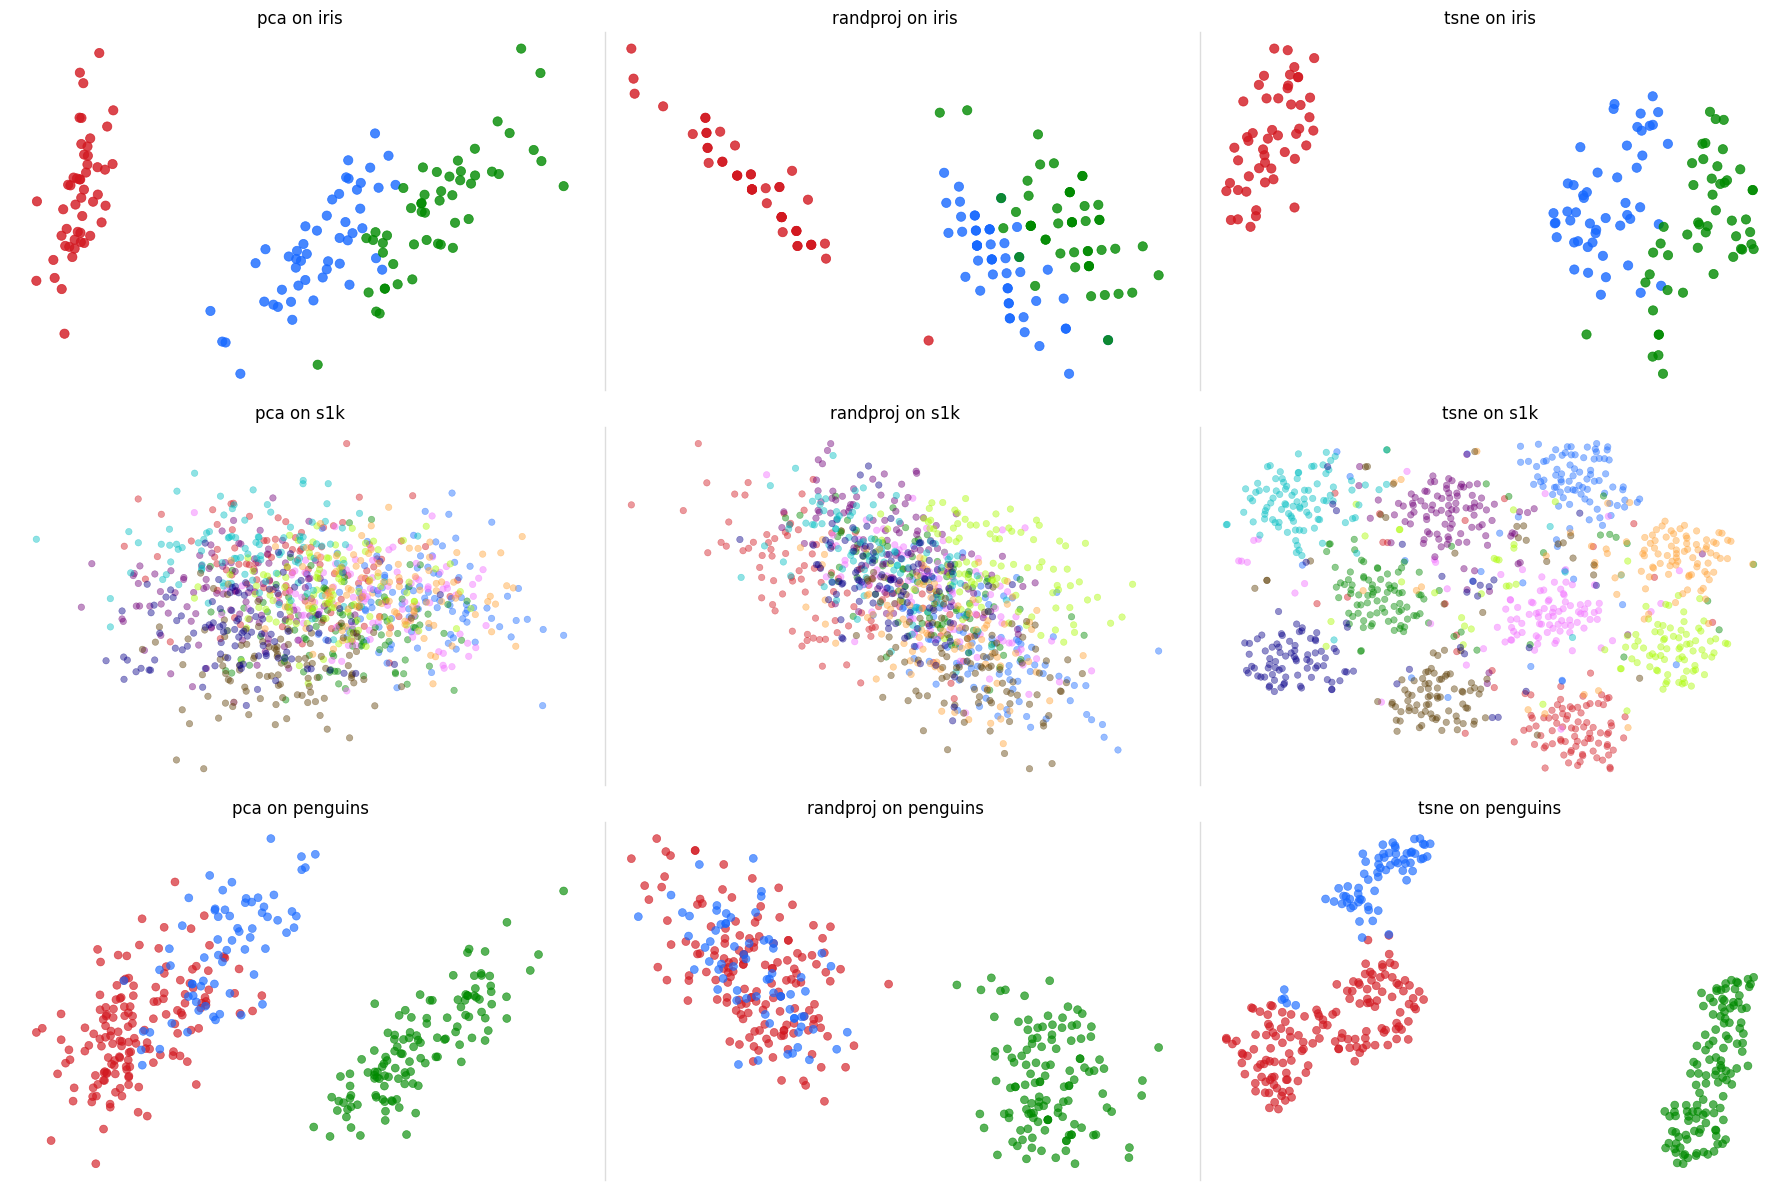

In [31]:
merged_experiments.plot()

In [32]:
merged_experiments.status()

,pca,randproj,tsne
iris,completed,completed,completed
s1k,completed,completed,completed
penguins,completed,completed,completed


## Version Reporting

If you want to see which version was used for each package, the `versions()` method returns a
dictionary mapping from the embedder name to another dict containing the package name and its
version string.

In [33]:
merged_experiments.versions()

{'pca': {'package': 'scikit-learn', 'version': '1.6.0'},
 'randproj': {'package': 'scikit-learn', 'version': '1.6.0'},
 'tsne': {'package': 'openTSNE', 'version': '1.0.4'}}

It's possible due to checkpointing that you could accidentally install a newer version of a package
and then only run part of the data with the old version and the rest with the new version. If this
happens, a warning will be logged about multiple versions and the returned dictionary will map from
the method name to a dictionary which maps from the dataset name to the package/version data, so
that you know which version acted on which dataset. This is probably not a good situation to be in:
if you want to compare results between two different versions of the same embedder, you should make
two separate plugins with two separate names.